<a href="https://colab.research.google.com/github/SejalM30/EEG_Project/blob/main/EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
!mkdir -p /content/eeg_project/data /content/eeg_project/outputs
%cd /content/eeg_project

!pip install -q numpy pandas scikit-learn matplotlib seaborn torch tqdm scipy


/content/eeg_project


In [2]:
from google.colab import files
uploaded = files.upload()


Saving EEG_data.csv to EEG_data.csv


In [3]:
# Imports and inspect
import os, random, math, time
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from scipy.signal import welch

DATA_PATH = Path("EEG_data.csv")
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
print("Unique students:", df["subject_id"].nunique())
print("Label distribution (subject_understood):")
print(df["subject_understood"].value_counts())
# Features present
POW_COLS = [c for c in df.columns if c.startswith("POW.")]
EEG_COLS = [c for c in df.columns if c.startswith("EEG.")]
print("Found POW cols:", len(POW_COLS), "Found EEG cols:", len(EEG_COLS))


Loaded: EEG_data.csv shape: (68831, 87)
Unique students: 8
Label distribution (subject_understood):
subject_understood
1    54370
0    14461
Name: count, dtype: int64
Found POW cols: 70 Found EEG cols: 14


In [4]:
# Compute per-subject mean POW vector
sub_means = df.groupby("subject_id")[POW_COLS].mean()
print("Per-subject POW mean shape:", sub_means.shape)

# Standardize
scaler = StandardScaler()
X_sub = scaler.fit_transform(sub_means.values)

# KMeans k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
sub_clusters = kmeans.fit_predict(X_sub)

# Add cluster column
sub_means["cluster"] = sub_clusters

# Reset index to make subject_id a column
sub_means = sub_means.reset_index()

print("Cluster counts (original subjects):")
print(pd.Series(sub_clusters).value_counts())

# Map cluster id -> cognitive label
alpha_cols = [c for c in POW_COLS if ".Alpha" in c]
if len(alpha_cols) == 0:
    alpha_means = sub_means[POW_COLS].mean(axis=1)
else:
    alpha_means = sub_means[alpha_cols].mean(axis=1)

cluster_alpha = sub_means.groupby("cluster")[alpha_cols].mean().mean(axis=1) if len(alpha_cols)>0 else sub_means.groupby("cluster")[POW_COLS].mean().mean(axis=1)
cluster_order = cluster_alpha.sort_values().index.tolist()

label_map_cluster = {
    cluster_order[0]: "Naive",
    cluster_order[1]: "Developing",
    cluster_order[2]: "Sophisticated"
}

subject_label_map = {int(r["subject_id"]): label_map_cluster[int(r["cluster"])] for _, r in sub_means.iterrows()}
print("Cluster -> label map:", label_map_cluster)
print("Subject -> assigned label (original subjects):")
for sid in subject_label_map:
    print(sid, subject_label_map[sid])


Per-subject POW mean shape: (8, 70)
Cluster counts (original subjects):
1    5
0    2
2    1
Name: count, dtype: int64
Cluster -> label map: {1: 'Naive', 0: 'Developing', 2: 'Sophisticated'}
Subject -> assigned label (original subjects):
0 Naive
1 Naive
2 Sophisticated
3 Naive
4 Naive
5 Developing
6 Developing
7 Naive


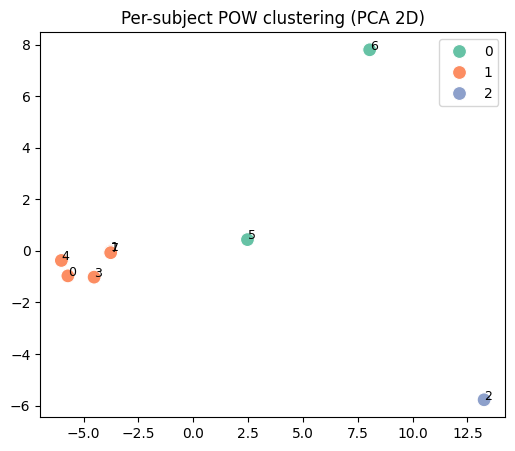

In [5]:
# Visualize cluster separation with PCA for debug
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sub)
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=sub_clusters, palette="Set2", s=100)
for i, sid in enumerate(sub_means.index):
    plt.text(X_pca[i,0]+0.01, X_pca[i,1]+0.01, str(sid), fontsize=9)
plt.title("Per-subject POW clustering (PCA 2D)")
plt.show()


In [6]:
#  prepare time-series grouped by subject and video to sample from.
# We'll extract sequences from EEG channels for augmentation and epoch creation.

# ensure data sorted by subject_id and video_id (and time if exists)
group_cols = ["subject_id","video_id"]
if "time" in df.columns:
    group_cols.append("time")
df_sorted = df.sort_values(group_cols).reset_index(drop=True)

# aggregate per (subject,video) continuous arrays
grouped = {}
for (sid, vid), g in df_sorted.groupby(["subject_id","video_id"]):
    arr = g[EEG_COLS].values  # shape (n_samples, n_channels)
    grouped[(int(sid), int(vid))] = arr

print("Prepared grouped arrays for (subject,video). Example count:", len(grouped))


Prepared grouped arrays for (subject,video). Example count: 11


In [7]:
# Simulation params and augment functions
NUM_SYNTHETIC_STUDENTS = 1000
EPOCH_SECONDS = 4
FS = 128   # assumed sampling rate; used only for epoch length in samples
SEQ_LEN = int(FS * EPOCH_SECONDS)   # 512
EPOCHS_PER_STUDENT = 20   # number of epochs to synthesize per synthetic student (tuneable)
STRIDE = SEQ_LEN // 2     # not used here; we randomly sample starts
AUG_NOISE_STD = 0.01      # relative noise
AUG_SCALE_RANGE = (0.9, 1.1)

random.seed(42)
np.random.seed(42)

def augment_segment(seg):
    # seg: numpy array (seq_len, n_channels)
    # 1) small amplitude scaling per channel
    scale = np.random.uniform(AUG_SCALE_RANGE[0], AUG_SCALE_RANGE[1], size=(seg.shape[1],))
    seg = seg * scale.reshape(1,-1)
    # 2) add gaussian noise relative to std
    noise = np.random.normal(0, AUG_NOISE_STD * np.std(seg, axis=0, keepdims=True), seg.shape)
    seg = seg + noise
    return seg

# Build mapping: cluster -> list of source (subject,video) keys
cluster_to_sources = {}
for subj in sub_means.index:
    cluster_id = int(sub_means.loc[subj,"cluster"])
    sources = [k for k in grouped.keys() if k[0] == int(subj)]
    if sources:
        cluster_to_sources.setdefault(cluster_id, []).extend(sources)

for c in cluster_to_sources:
    print("Cluster", c, "source groups:", len(cluster_to_sources[c]))


Cluster 1 source groups: 8
Cluster 2 source groups: 1
Cluster 0 source groups: 2


In [8]:
# Generate synthetic students
synthetic_students = {}  # id -> dict with 'epochs' (list of arrays), 'label' (str)
all_epochs = []
all_labels = []
all_student_ids = []

start_time = time.time()
for new_id in tqdm(range(NUM_SYNTHETIC_STUDENTS)):
    # randomly choose a cluster proportional to cluster sizes (use kmeans counts)
    cluster_choice = np.random.choice(list(sub_means['cluster'].value_counts().index), p=(sub_means['cluster'].value_counts()/sub_means['cluster'].value_counts().sum()).values)
    # choose a random source (subject,video) from that cluster
    sources = cluster_to_sources.get(cluster_choice)
    if not sources:
        # fallback to any grouped source
        sources = list(grouped.keys())
    # sample epochs by repeatedly picking a random source and extracting a random window
    student_epochs = []
    for e in range(EPOCHS_PER_STUDENT):
        src = random.choice(sources)
        arr = grouped[src]
        if arr.shape[0] < SEQ_LEN:
            # if too short, skip by sampling from other source
            continue
        # choose random start
        start_idx = random.randint(0, arr.shape[0] - SEQ_LEN)
        seg = arr[start_idx:start_idx+SEQ_LEN].copy()
        seg = augment_segment(seg)
        student_epochs.append(seg)
        # save to global lists
        all_epochs.append(seg)
        all_labels.append(label_map_cluster[cluster_choice])  # label as text
        all_student_ids.append(new_id)
    synthetic_students[new_id] = {"epochs": student_epochs, "label": label_map_cluster[cluster_choice]}

elapsed = time.time() - start_time
print(f"Created synthetic students: {len(synthetic_students)}, total epochs: {len(all_epochs)} (time {elapsed:.1f}s)")
all_epochs = np.stack(all_epochs)   # (N, seq_len, n_channels)
print("All epochs shape:", all_epochs.shape)


100%|██████████| 1000/1000 [00:11<00:00, 84.41it/s]


Created synthetic students: 1000, total epochs: 20000 (time 11.9s)
All epochs shape: (20000, 512, 14)


In [9]:
#  Label encoding
label_to_num = {"Naive":0, "Developing":1, "Sophisticated":2}
y_text = np.array(all_labels)
y_num = np.array([label_to_num[t] for t in y_text])
groups = np.array(all_student_ids)   # synthetic student id per epoch

print("Epochs:", all_epochs.shape, "Labels:", y_num.shape, "Unique students:", len(np.unique(groups)))


Epochs: (20000, 512, 14) Labels: (20000,) Unique students: 1000


In [10]:
# Dataset & Transformer
import torch
from torch.utils.data import Dataset, DataLoader

class EEGEpochDataset(Dataset):
    def __init__(self, X, y, groups=None, augment=False):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.groups = groups
        self.augment = augment
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx].copy()
        if self.augment:
            x = augment_segment(x)   # additional augmentation
        # per-epoch normalization channel-wise
        x = (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-6)
        return torch.from_numpy(x), torch.tensor(self.y[idx])

# Transformer model (encoder only)
class SimpleEEGTransformer(nn.Module):
    def __init__(self, n_channels, n_classes=3, d_model=128, n_heads=8, num_layers=3, d_ff=512):
        super().__init__()
        self.proj = nn.Linear(n_channels, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, n_classes)
    def forward(self, x):   # x: (batch, seq_len, n_channels)
        x = self.proj(x)    # -> (batch, seq_len, d_model)
        x = self.encoder(x) # -> (batch, seq_len, d_model)
        x = x.mean(dim=1)   # global average over time
        x = self.norm(x)
        return self.classifier(x)


In [20]:
# Training loop with GroupKFold (split by synthetic student IDs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

BATCH_SIZE = 64
LR = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 12   # raise later if needed
NUM_WORKERS = 2

unique_students = np.unique(groups)
print("Total synthetic students:", len(unique_students))

gkf = GroupKFold(n_splits=5)
fold_results = []

# -------- Initialize DataFrame to store all student predictions --------
all_student_results = pd.DataFrame(columns=["student_id", "predicted_class_num", "predicted_class"])

num_to_label = {0: "Naive", 1: "Developing", 2: "Sophisticated"}

for fold, (train_idx, test_idx) in enumerate(gkf.split(all_epochs, y_num, groups), 1):
    print(f"\n=== Fold {fold}/5 ===")
    X_tr, y_tr, g_tr = all_epochs[train_idx], y_num[train_idx], groups[train_idx]
    X_te, y_te, g_te = all_epochs[test_idx], y_num[test_idx], groups[test_idx]

    train_ds = EEGEpochDataset(X_tr, y_tr, augment=True)
    test_ds = EEGEpochDataset(X_te, y_te, augment=False)
    tr_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    te_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    model = SimpleEEGTransformer(n_channels=all_epochs.shape[2], n_classes=3).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    crit = nn.CrossEntropyLoss()

    best_val_student_acc = 0.0
    best_state = None

    for ep in range(1, EPOCHS + 1):
        # -------- TRAIN --------
        model.train()
        total_loss = 0.0
        for xb, yb in tr_loader:
            xb, yb = xb.to(device).float(), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = crit(out, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
        avg_loss = total_loss / len(tr_loader.dataset)

        # -------- EVALUATE --------
        model.eval()
        y_true_epoch, y_pred_epoch = [], []
        with torch.no_grad():
            for xb, yb in te_loader:
                xb = xb.to(device).float()
                out = model(xb)
                p = out.argmax(dim=1).cpu().numpy()
                y_pred_epoch.extend(p.tolist())
                y_true_epoch.extend(yb.numpy().tolist())

        # -------- PER-STUDENT MAJORITY VOTE --------
        preds_by_student = {}
        true_by_student = {}
        for idx_local, global_idx in enumerate(test_idx):
            student = int(groups[global_idx])
            preds_by_student.setdefault(student, []).append(y_pred_epoch[idx_local])
            true_by_student.setdefault(student, []).append(y_te[idx_local])

        y_true_students, y_pred_students = [], []
        for student in preds_by_student:
            pred = max(set(preds_by_student[student]), key=preds_by_student[student].count)
            true = max(set(true_by_student[student]), key=true_by_student[student].count)
            y_true_students.append(true)
            y_pred_students.append(pred)

        # -------- Append fold student predictions to all_student_results --------
        student_results = pd.DataFrame({
            "student_id": list(preds_by_student.keys()),
            "predicted_class_num": y_pred_students,
            "predicted_class": [num_to_label[i] for i in y_pred_students]
        })
        all_student_results = pd.concat([all_student_results, student_results], ignore_index=True)

        student_acc = accuracy_score(y_true_students, y_pred_students)
        if student_acc > best_val_student_acc:
            best_val_student_acc = student_acc
            best_state = model.state_dict().copy()

        print(f"Epoch {ep:02d} | loss {avg_loss:.4f} | student-acc {student_acc:.4f}")

    # -------- SAVE RESULTS --------
    fold_results.append({"fold": fold, "best_student_acc": float(best_val_student_acc)})
    torch.save(best_state, f"outputs/transformer_fold{fold}_best.pth")
    print(f"Fold {fold} best student accuracy: {best_val_student_acc:.4f}")

# -------- AFTER ALL FOLDS --------
print("\nAll folds results:")
print(fold_results)
avg_acc = np.mean([r["best_student_acc"] for r in fold_results])
print(f"\nMean per-student accuracy across folds: {avg_acc:.4f}")

Device: cuda
Total synthetic students: 1000

=== Fold 1/5 ===
Epoch 01 | loss 0.1730 | student-acc 1.0000
Epoch 02 | loss 0.0055 | student-acc 1.0000
Epoch 03 | loss 0.0017 | student-acc 1.0000
Epoch 04 | loss 0.0009 | student-acc 1.0000
Epoch 05 | loss 0.0006 | student-acc 1.0000
Epoch 06 | loss 0.0005 | student-acc 1.0000
Epoch 07 | loss 0.0004 | student-acc 1.0000
Epoch 08 | loss 0.0003 | student-acc 1.0000
Epoch 09 | loss 0.0002 | student-acc 1.0000
Epoch 10 | loss 0.0002 | student-acc 1.0000
Epoch 11 | loss 0.0002 | student-acc 1.0000
Epoch 12 | loss 0.0001 | student-acc 1.0000
Fold 1 best student accuracy: 1.0000

=== Fold 2/5 ===
Epoch 01 | loss 0.1912 | student-acc 1.0000
Epoch 02 | loss 0.0062 | student-acc 1.0000
Epoch 03 | loss 0.0015 | student-acc 1.0000
Epoch 04 | loss 0.0009 | student-acc 1.0000
Epoch 05 | loss 0.0006 | student-acc 1.0000
Epoch 06 | loss 0.0005 | student-acc 1.0000
Epoch 07 | loss 0.0004 | student-acc 1.0000
Epoch 08 | loss 0.0003 | student-acc 1.0000
Epo

Per-student classification report:
               precision    recall  f1-score   support

        Naive       1.00      1.00      1.00       144
   Developing       1.00      1.00      1.00        36
Sophisticated       1.00      1.00      1.00        20

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200



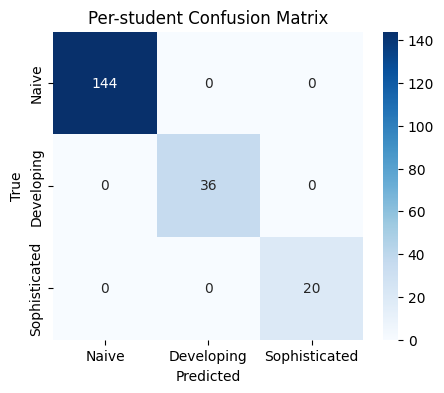

In [25]:
#Evaluate final saved best model on one fold (the last)
import json
last_fold = fold_results[-1]["fold"]
ckpt_path = f"outputs/transformer_fold{last_fold}_best.pth"
model = SimpleEEGTransformer(n_channels=all_epochs.shape[2], n_classes=3).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

# pick the last test split (we still have gkf object earlier; recompute one split to retrieve indices)
splits = list(GroupKFold(n_splits=5).split(all_epochs, y_num, groups))
train_idx, test_idx = splits[-1]
X_te, y_te, g_te = all_epochs[test_idx], y_num[test_idx], groups[test_idx]

te_ds = EEGEpochDataset(X_te, y_te, augment=False)
te_loader = DataLoader(te_ds, batch_size=128, shuffle=False)

# per-epoch preds
y_pred_epoch = []
y_true_epoch = []
with torch.no_grad():
    for xb, yb in te_loader:
        xb = xb.to(device)
        out = model(xb)
        p = out.argmax(dim=1).cpu().numpy()
        y_pred_epoch.extend(p.tolist())
        y_true_epoch.extend(yb.numpy().tolist())

# per-student majority vote
preds_by_student, true_by_student = {}, {}
for idx_local, global_idx in enumerate(test_idx):
    student = int(groups[global_idx])
    preds_by_student.setdefault(student, []).append(y_pred_epoch[idx_local])
    true_by_student.setdefault(student, []).append(y_true_epoch[idx_local])

y_true_students, y_pred_students = [], []
for student in preds_by_student:
    pred = max(set(preds_by_student[student]), key=preds_by_student[student].count)
    true = max(set(true_by_student[student]), key=true_by_student[student].count)
    y_true_students.append(true); y_pred_students.append(pred)

print("Per-student classification report:")
print(classification_report(y_true_students, y_pred_students, target_names=["Naive","Developing","Sophisticated"]))
cm = confusion_matrix(y_true_students, y_pred_students)
plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Naive","Developing","Sophisticated"],
            yticklabels=["Naive","Developing","Sophisticated"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Per-student Confusion Matrix"); plt.show()


In [24]:
y_true_students
y_pred_students
groups
label_to_num = {"Naive":0, "Developing":1, "Sophisticated":2}


In [23]:
# Map numeric predictions back to text labels
num_to_label = {0:"Naive", 1:"Developing", 2:"Sophisticated"}

# Use the student IDs corresponding to the predictions in this fold
students_in_fold = list(preds_by_student.keys())

student_results = pd.DataFrame({
    "student_id": students_in_fold,
    "predicted_class_num": y_pred_students,
    "predicted_class": [num_to_label[i] for i in y_pred_students],
    "true_class_num": y_true_students,
    "true_class": [num_to_label[i] for i in y_true_students]
})

print("Per-student predicted cognition class:")
print(student_results.head(10))


Per-student predicted cognition class:
   student_id  predicted_class_num predicted_class  true_class_num  \
0           4                    0           Naive               0   
1          10                    0           Naive               0   
2          15                    0           Naive               0   
3          16                    2   Sophisticated               2   
4          21                    1      Developing               1   
5          27                    0           Naive               0   
6          33                    0           Naive               0   
7          38                    1      Developing               1   
8          44                    0           Naive               0   
9          50                    0           Naive               0   

      true_class  
0          Naive  
1          Naive  
2          Naive  
3  Sophisticated  
4     Developing  
5          Naive  
6          Naive  
7     Developing  
8          Naive  


In [22]:
student_id = 1
predicted_class = student_results.loc[student_results["student_id"] == student_id, "predicted_class"].values[0] if not student_results.loc[student_results["student_id"] == student_id].empty else None

print(f"Student {student_id} belongs to class: {predicted_class}")


Student 1 belongs to class: None
